In [9]:
from scipy import stats
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
L21 = 0.1
L31 = -0.6
L41 = -0.7
L51 = 0
L61 = 0.4
L71 = 0.2
L32 = 0
L42 = -0.1
L52 = 0.4
L62 = 0.1
L72 = 0.1
L43 = 0.2
L53 = -0.4
L63 = 0.6
L73 = 0.01
L54 = 0.4
L64 = 0.1
L74 = -0.3
L65 = 0.3
L75 = 0.5
L76 = 0.2

In [12]:
L11 = 1

if 1-L21**2 >=0:
    L22 = np.sqrt(1-L21**2)
else:
    raise ValueError('1-L21**2 must be >=0')

if 1-L31**2-L32**2 >=0:
    L33 = np.sqrt(1-L31**2-L32**2)
else:
    raise ValueError('1-L31**2-L32**2 must be >=0')

if 1-L41**2-L42**2-L43**2 >=0:
    L44 = np.sqrt(1-L41**2-L42**2-L43**2)
else:
    raise ValueError('1-L41**2-L42**2-L43**2 must be >=0')

if 1-L51**2-L52**2-L53**2-L54**2 >=0:
    L55 = np.sqrt(1-L51**2-L52**2-L53**2-L54**2)
else:
    raise ValueError('1-L51**2-L52**2-L53**2-L54**2 must be >=0')

if 1-L61**2-L62**2-L63**2-L64**2-L65**2 >=0:
    L66 = np.sqrt(1-L61**2-L62**2-L63**2-L64**2-L65**2)
else:
    raise ValueError('1-L61**2-L62**2-L63**2-L64**2-L65**2 must be >=0')

if 1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2 >=0:
    L77 = np.sqrt(1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2)
else:
    raise ValueError('1-L71**2-L72**2-L73**2-L74**2-L75**2-L76**2 must be >=0')

In [13]:
L = [[L11, 0, 0, 0, 0, 0, 0],
     [L21, L22, 0, 0, 0, 0, 0],
     [L31, L32, L33, 0, 0, 0, 0],
     [L41, L42, L43, L44, 0, 0, 0],
     [L51, L52, L53, L54, L55, 0, 0],
     [L61, L62, L63, L64, L65, L66, 0],
     [L71, L72, L73, L74, L75, L76, L77]]

In [14]:
covmat_Z = np.dot(L, np.transpose(L))
print(covmat_Z.shape)

# The covariance (=correlation here) matrix must be non-singular and positive semi-definite: verification
if not np.all(np.linalg.eigvals(covmat_Z) >= 0):
    raise ValueError('The covariance matrix is not positive semi-definite')
if round(np.linalg.det(covmat_Z), 6) == 0:
    raise ValueError('The covariance matrix is singular')
# All entries must be in [-1,1]
if not np.all(np.abs(covmat_Z <= 1)):
    raise ValueError('All entries of the correlation matrix must be in [-1,1]')

(7, 7)


In [15]:
mvnorm = stats.multivariate_normal(mean=np.zeros(covmat_Z.shape[0]), cov=covmat_Z)

m1 = stats.norm(2,0.6)
m2 = stats.norm(0.2,0.3)
m3 = stats.norm(-0.3,2)
m4 = stats.norm(0.7,0.4)
m5 = stats.uniform()
m6 = stats.uniform()
m7 = stats.uniform()

p_a = 0.3
tau_a = 1 - p_a

p_b = 0.9
tau_b = 1-p_b

p_y = 0.2
tau_y = 1 - p_y

In [16]:
!mkdir bias_data

datasets=[]
for i in tqdm(range(100)):
    z = mvnorm.rvs(100000)
    u = stats.norm.cdf(z)
    x1 = m1.ppf(u[:, 0])
    x2 = m2.ppf(u[:, 1])
    x3 = m3.ppf(u[:, 2])
    x4 = m4.ppf(u[:, 3])
    x5 = m5.ppf(u[:, 4])
    x6 = m6.ppf(u[:, 5])
    x7 = m7.ppf(u[:, 6])
    a = np.zeros(len(x5), dtype=int)
    a[x5 >= tau_a] = 1
    b = np.zeros(len(x6), dtype=int)
    b[x6 >= tau_b] = 1
    y = np.zeros(len(x7), dtype=int)
    y[x7 >= tau_y] = 1
    data = pd.DataFrame({'X1':x1, 'X2':x2, 'X3':x3, 'X4':x4, 'A':a, 'B':b, 'Y':y})
#     data.to_csv('bias_data/synthetic_data_v2010_' + str(i) + '.csv', index=False)
    datasets.append(data)

100%|██████████| 100/100 [00:11<00:00,  8.44it/s]


In [17]:
datasets[0]

,X1,X2,X3,X4,A,B,Y
0,1.289107,-0.010057,1.416104,0.793413,0,1,0
1,1.052155,0.201157,-0.064636,0.758822,0,0,0
2,1.842873,0.240821,1.331408,1.085912,1,1,1
3,1.922681,0.335380,-3.041600,0.479981,1,0,1
4,1.886878,0.300403,-0.120959,0.756994,0,1,0
...,...,...,...,...,...,...,...
99995,2.359245,0.351350,-1.835533,0.590723,0,1,0
99996,2.605865,-0.251216,-2.847853,0.293579,0,1,1
99997,3.287034,0.882184,-0.901484,-0.005084,0,1,0
99998,1.268541,0.196396,4.695806,1.261942,0,1,0


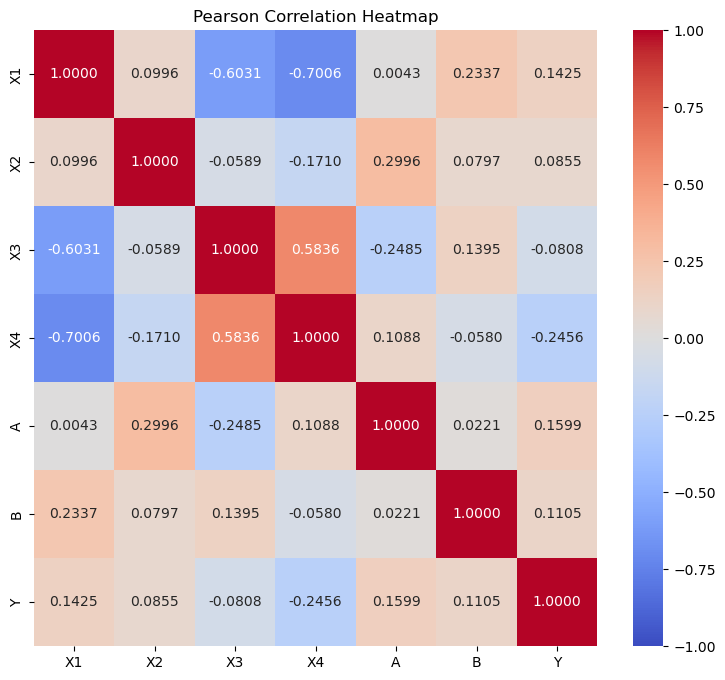

In [18]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim-2)
        self.relu = nn.ReLU()
    def forward(self, x):
#         return self.relu(self.fc1(x))
        return self.fc1(x)

In [20]:
class Predictor(nn.Module):
    def __init__(self, input_dim):
        super(Predictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.fc1(x))

In [21]:
class Adversary(nn.Module):
    def __init__(self, input_dim):
        super(Adversary, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.fc1(x))

In [22]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe[['X1', 'X2', 'X3', 'X4', 'A', 'B']].values, dtype=torch.float32)
#         self.A = torch.tensor(dataframe[['A']].values, dtype=torch.float32)
#         self.B = torch.tensor(dataframe[['B']].values, dtype=torch.float32)
        self.Y = torch.tensor(dataframe[['Y']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
#         return self.X[idx], self.A[idx], self.B[idx], self.Y[idx]
        return self.X[idx], self.Y[idx]

dataset = CustomDataset(datasets[0])
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

In [23]:
encoder = Encoder(6)
predictor = Predictor(4)
adversaryA = Adversary(4)
adversaryB = Adversary(4)

In [24]:
learning_rate = 0.01

criterion_enc = nn.MSELoss()
criterion_pred = nn.BCELoss()
criterion_advA = nn.BCELoss()
criterion_advB = nn.BCELoss()

optimizer_pred = optim.Adam(predictor.parameters(), lr=learning_rate)
optimizer_advA = optim.Adam(adversaryA.parameters(), lr=learning_rate)
optimizer_advB = optim.Adam(adversaryB.parameters(), lr=learning_rate)
optimizer_enc = optim.Adam(encoder.parameters(), lr=learning_rate)

In [25]:
for a,b in dataloader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([256, 6])
torch.Size([256, 1])


In [26]:
num_epochs = 5
encoder.train()

gradient_norms_enc = []
epochs_enc = []

In [93]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        encoder.zero_grad()
        x_recon = encoder(data)
        lx = criterion_enc(x_recon, data[:,:4])
        lx.backward()

        batch_gradient_norm = 0.0
        for p in encoder.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_enc.step()
    
    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_enc.append(average_gradient_norm)
    epochs_enc.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Recon: {lx.item():.4f}')

Epoch [1/5], Loss Recon: 0.0039
Epoch [2/5], Loss Recon: 0.0003
Epoch [3/5], Loss Recon: 0.0001
Epoch [4/5], Loss Recon: 0.0000
Epoch [5/5], Loss Recon: 0.0000


In [94]:
gradient_norms_enc

[0.41592138277618,
 0.012199086007103049,
 0.0036769176916042045,
 0.001619835536264081,
 0.000704601372657161]

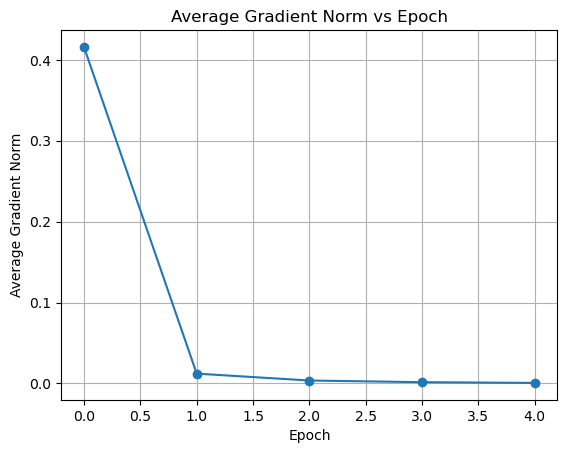

In [95]:
plt.plot(epochs_enc, gradient_norms_enc, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [96]:
# index = 0
# df_original = datasets[index].copy()

# dataset = CustomDataset(df_original)
# dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# encoder_outputs = []
# encoder.eval()
# with torch.no_grad():
#     for batch_X, _ in dataloader:
#         output = encoder(batch_X)
#         encoder_outputs.append(output)
# encoder_outputs = torch.cat(encoder_outputs, dim=0)

# encoder_outputs_np = encoder_outputs.numpy()
# df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

# df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B], axis=1)

# correlation_matrix = df.corr()

# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

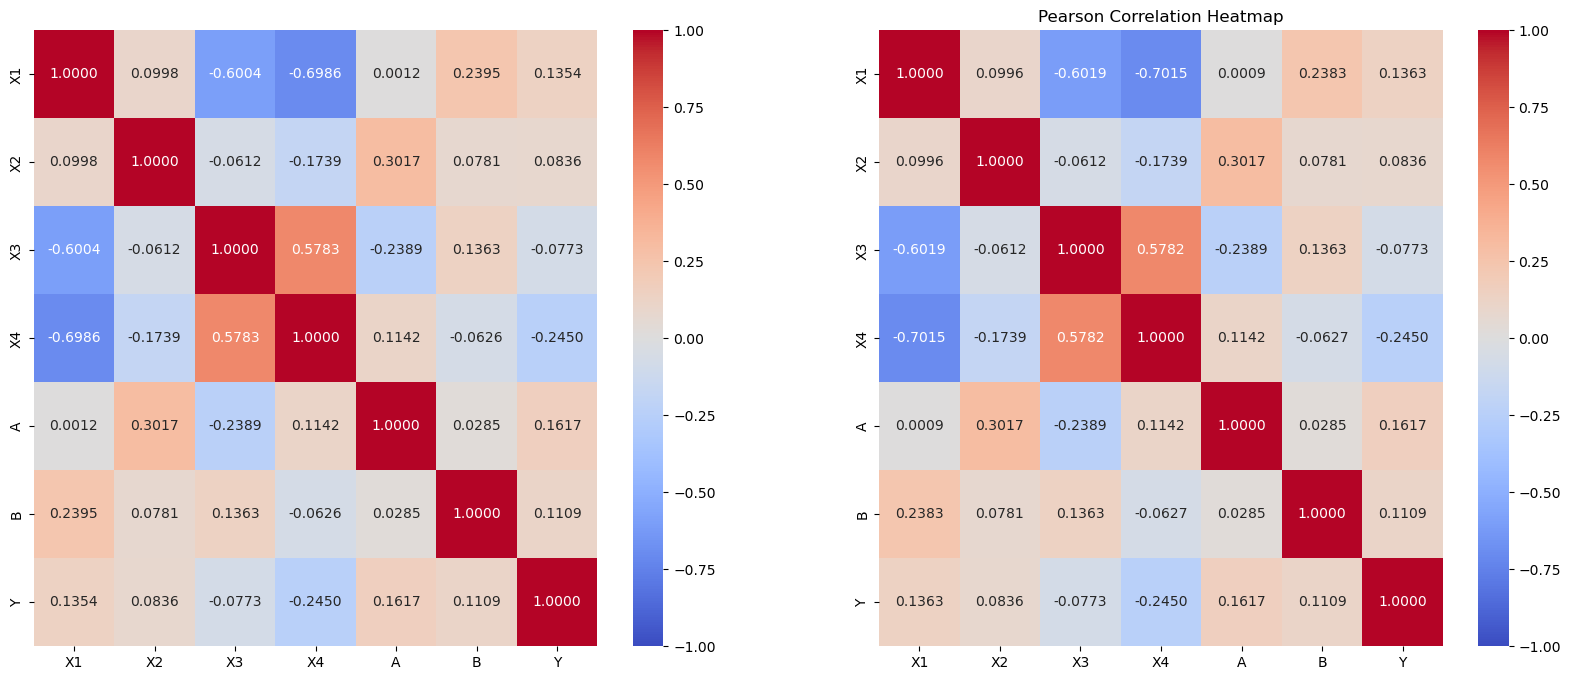

In [97]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [98]:
num_epochs = 30
predictor.train()

gradient_norms_pred = []
epochs_pred = []

In [99]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        predictor.zero_grad()
        x_recon = encoder(data)
        y_pred = predictor(x_recon.detach())
        lp = criterion_pred(y_pred, labels)
        lp.backward()
        
        batch_gradient_norm = 0.0
        for p in predictor.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_pred.step()
    
    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_pred.append(average_gradient_norm)
    epochs_pred.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Pred: {lp.item():.4f}')

Epoch [1/30], Loss Pred: 0.5338
Epoch [2/30], Loss Pred: 0.4930
Epoch [3/30], Loss Pred: 0.4398
Epoch [4/30], Loss Pred: 0.4315
Epoch [5/30], Loss Pred: 0.5094
Epoch [6/30], Loss Pred: 0.4955
Epoch [7/30], Loss Pred: 0.4189
Epoch [8/30], Loss Pred: 0.4049
Epoch [9/30], Loss Pred: 0.4074
Epoch [10/30], Loss Pred: 0.5294
Epoch [11/30], Loss Pred: 0.4475
Epoch [12/30], Loss Pred: 0.4687
Epoch [13/30], Loss Pred: 0.4419
Epoch [14/30], Loss Pred: 0.5174
Epoch [15/30], Loss Pred: 0.4661
Epoch [16/30], Loss Pred: 0.4482
Epoch [17/30], Loss Pred: 0.5030
Epoch [18/30], Loss Pred: 0.4195
Epoch [19/30], Loss Pred: 0.4795
Epoch [20/30], Loss Pred: 0.4328
Epoch [21/30], Loss Pred: 0.4421
Epoch [22/30], Loss Pred: 0.5036
Epoch [23/30], Loss Pred: 0.4584
Epoch [24/30], Loss Pred: 0.5113
Epoch [25/30], Loss Pred: 0.4085
Epoch [26/30], Loss Pred: 0.4582
Epoch [27/30], Loss Pred: 0.4408
Epoch [28/30], Loss Pred: 0.5340
Epoch [29/30], Loss Pred: 0.4450
Epoch [30/30], Loss Pred: 0.3563


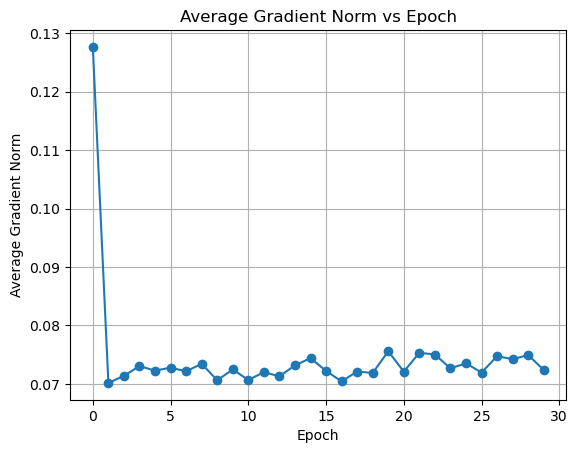

In [100]:
plt.plot(list(range(num_epochs)), gradient_norms_pred, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

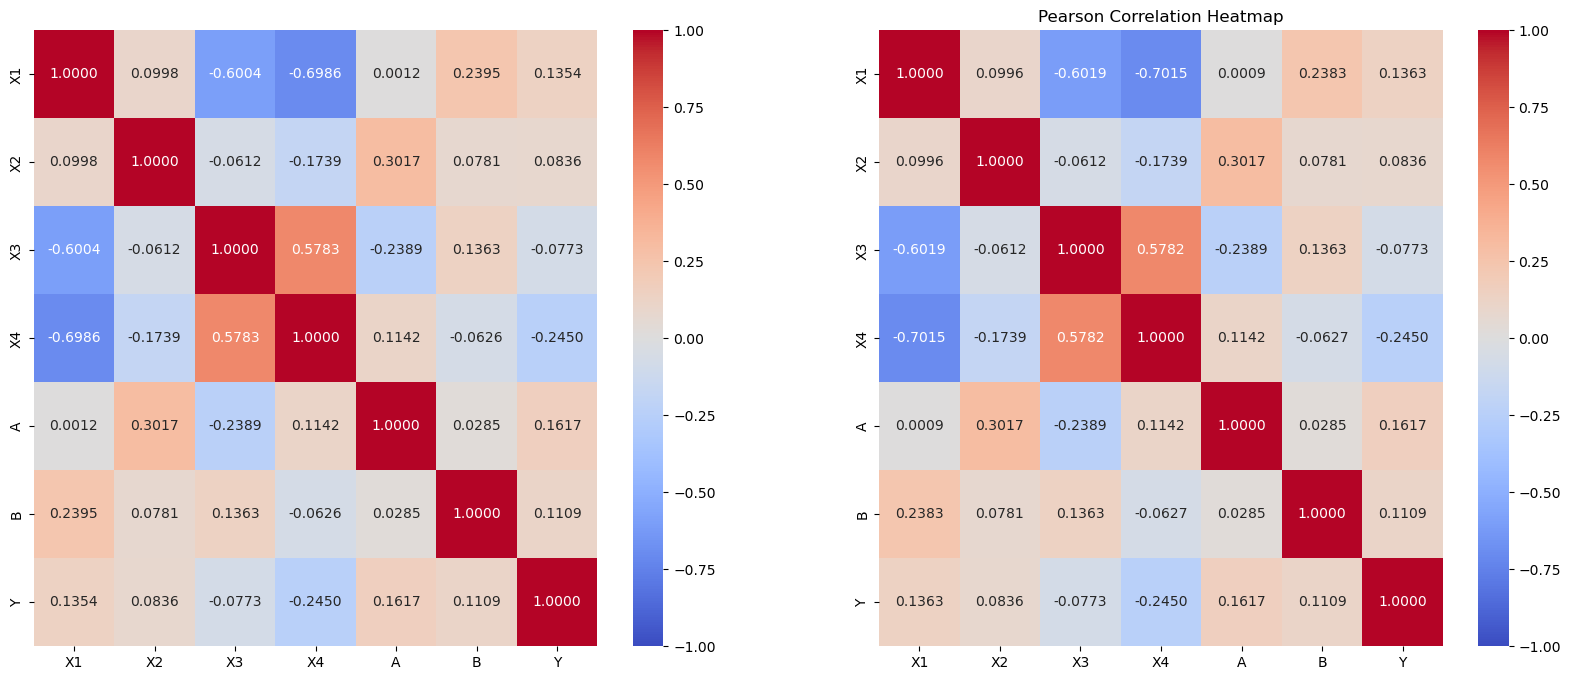

In [101]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [102]:
num_epochs = 30
adversaryA.train()

gradient_norms_advA = []
epochs_advA = []

In [103]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        adversaryA.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon.detach())
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laA.backward()
        
        batch_gradient_norm = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_advA.step()

    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_advA.append(average_gradient_norm)
    epochs_advA.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Adv A: {laA.item():.4f}')

Epoch [1/30], Loss Adv A: 0.4774
Epoch [2/30], Loss Adv A: 0.4809
Epoch [3/30], Loss Adv A: 0.4963
Epoch [4/30], Loss Adv A: 0.4704
Epoch [5/30], Loss Adv A: 0.4226
Epoch [6/30], Loss Adv A: 0.4780
Epoch [7/30], Loss Adv A: 0.4146
Epoch [8/30], Loss Adv A: 0.5469
Epoch [9/30], Loss Adv A: 0.4438
Epoch [10/30], Loss Adv A: 0.4105
Epoch [11/30], Loss Adv A: 0.4058
Epoch [12/30], Loss Adv A: 0.4504
Epoch [13/30], Loss Adv A: 0.4688
Epoch [14/30], Loss Adv A: 0.4276
Epoch [15/30], Loss Adv A: 0.4581
Epoch [16/30], Loss Adv A: 0.4128
Epoch [17/30], Loss Adv A: 0.3887
Epoch [18/30], Loss Adv A: 0.4833
Epoch [19/30], Loss Adv A: 0.4406
Epoch [20/30], Loss Adv A: 0.5232
Epoch [21/30], Loss Adv A: 0.5066
Epoch [22/30], Loss Adv A: 0.4427
Epoch [23/30], Loss Adv A: 0.4482
Epoch [24/30], Loss Adv A: 0.3929
Epoch [25/30], Loss Adv A: 0.4358
Epoch [26/30], Loss Adv A: 0.4335
Epoch [27/30], Loss Adv A: 0.4949
Epoch [28/30], Loss Adv A: 0.4652
Epoch [29/30], Loss Adv A: 0.4570
Epoch [30/30], Loss Adv

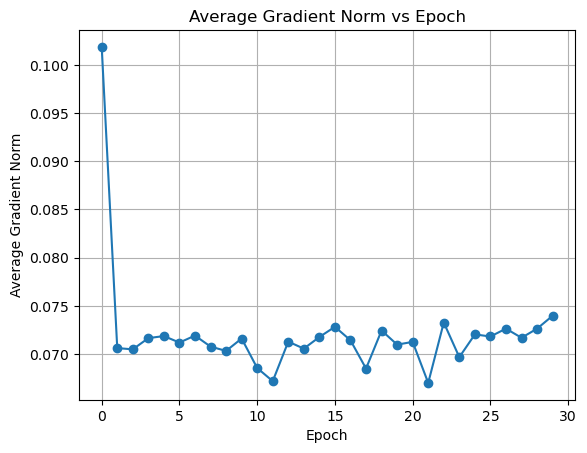

In [104]:
plt.plot(list(range(num_epochs)), gradient_norms_advA, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

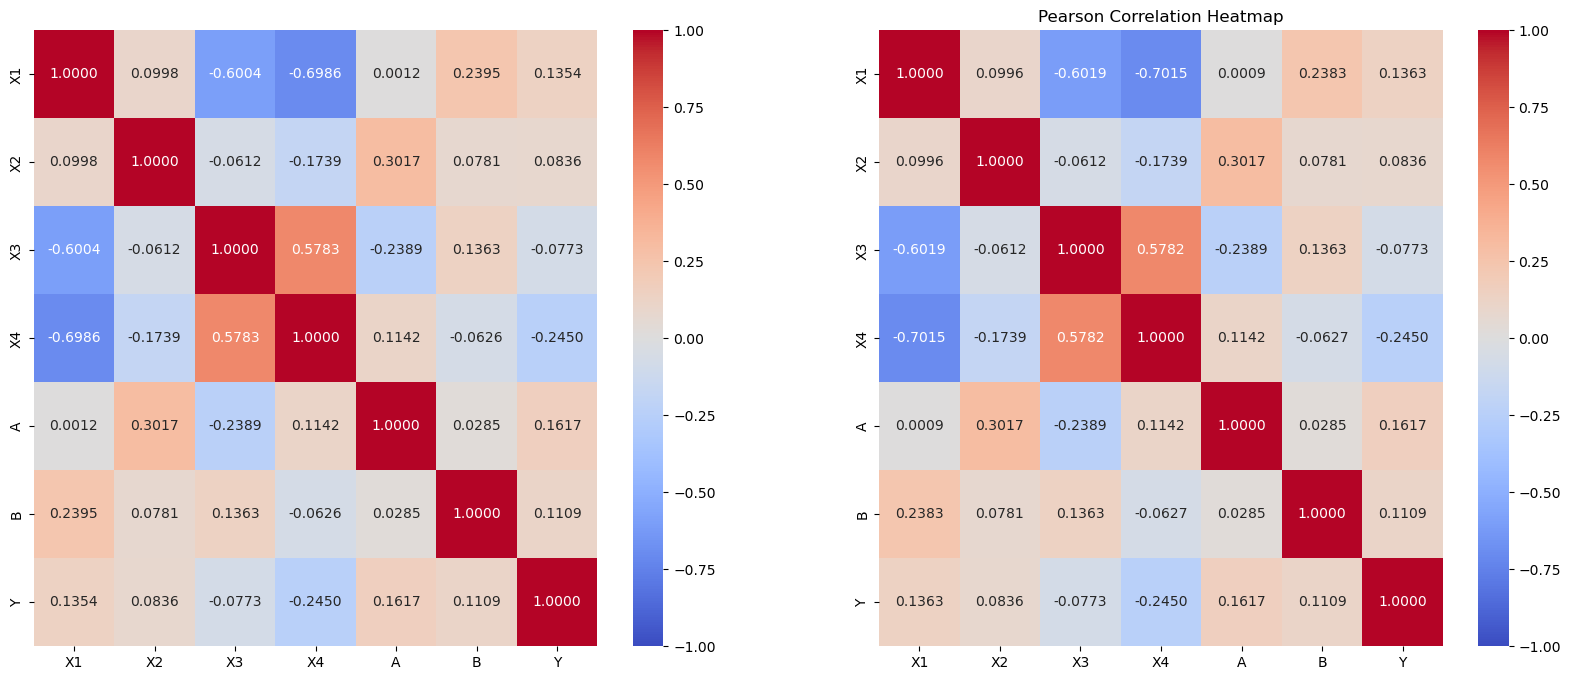

In [105]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [106]:
num_epochs = 30
adversaryB.train()

gradient_norms_advB = []
epochs_advB = []

In [107]:
for epoch in range(num_epochs):

    total_gradient_norm = 0.0
    num_batches = 0

    for data, labels in dataloader: 
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predB = adversaryB(x_recon.detach())
        laB = criterion_advB(adv_predB, data[:,4].view(-1,1).float())
        laB.backward()
        
        batch_gradient_norm = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm = batch_gradient_norm ** 0.5
        total_gradient_norm += batch_gradient_norm
        num_batches += 1

        optimizer_advB.step()

    average_gradient_norm = total_gradient_norm / num_batches
    gradient_norms_advB.append(average_gradient_norm)
    epochs_advB.append(epoch)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss Adv: {laB.item():.4f}')

Epoch [1/30], Loss Adv: 0.5478
Epoch [2/30], Loss Adv: 0.4347
Epoch [3/30], Loss Adv: 0.5194
Epoch [4/30], Loss Adv: 0.4426
Epoch [5/30], Loss Adv: 0.4248
Epoch [6/30], Loss Adv: 0.4821
Epoch [7/30], Loss Adv: 0.4296
Epoch [8/30], Loss Adv: 0.4766
Epoch [9/30], Loss Adv: 0.4433
Epoch [10/30], Loss Adv: 0.4750
Epoch [11/30], Loss Adv: 0.4005
Epoch [12/30], Loss Adv: 0.4518
Epoch [13/30], Loss Adv: 0.3844
Epoch [14/30], Loss Adv: 0.4495
Epoch [15/30], Loss Adv: 0.3287
Epoch [16/30], Loss Adv: 0.3958
Epoch [17/30], Loss Adv: 0.5253
Epoch [18/30], Loss Adv: 0.4822
Epoch [19/30], Loss Adv: 0.4794
Epoch [20/30], Loss Adv: 0.4389
Epoch [21/30], Loss Adv: 0.4238
Epoch [22/30], Loss Adv: 0.5294
Epoch [23/30], Loss Adv: 0.4283
Epoch [24/30], Loss Adv: 0.4545
Epoch [25/30], Loss Adv: 0.5179
Epoch [26/30], Loss Adv: 0.4360
Epoch [27/30], Loss Adv: 0.4353
Epoch [28/30], Loss Adv: 0.4442
Epoch [29/30], Loss Adv: 0.4228
Epoch [30/30], Loss Adv: 0.4566


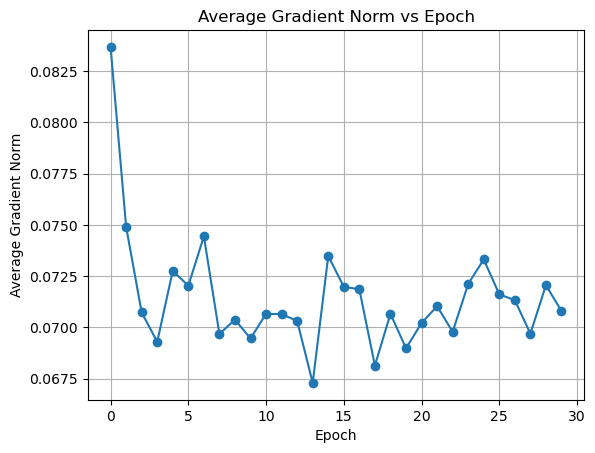

In [108]:
plt.plot(list(range(num_epochs)), gradient_norms_advB, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

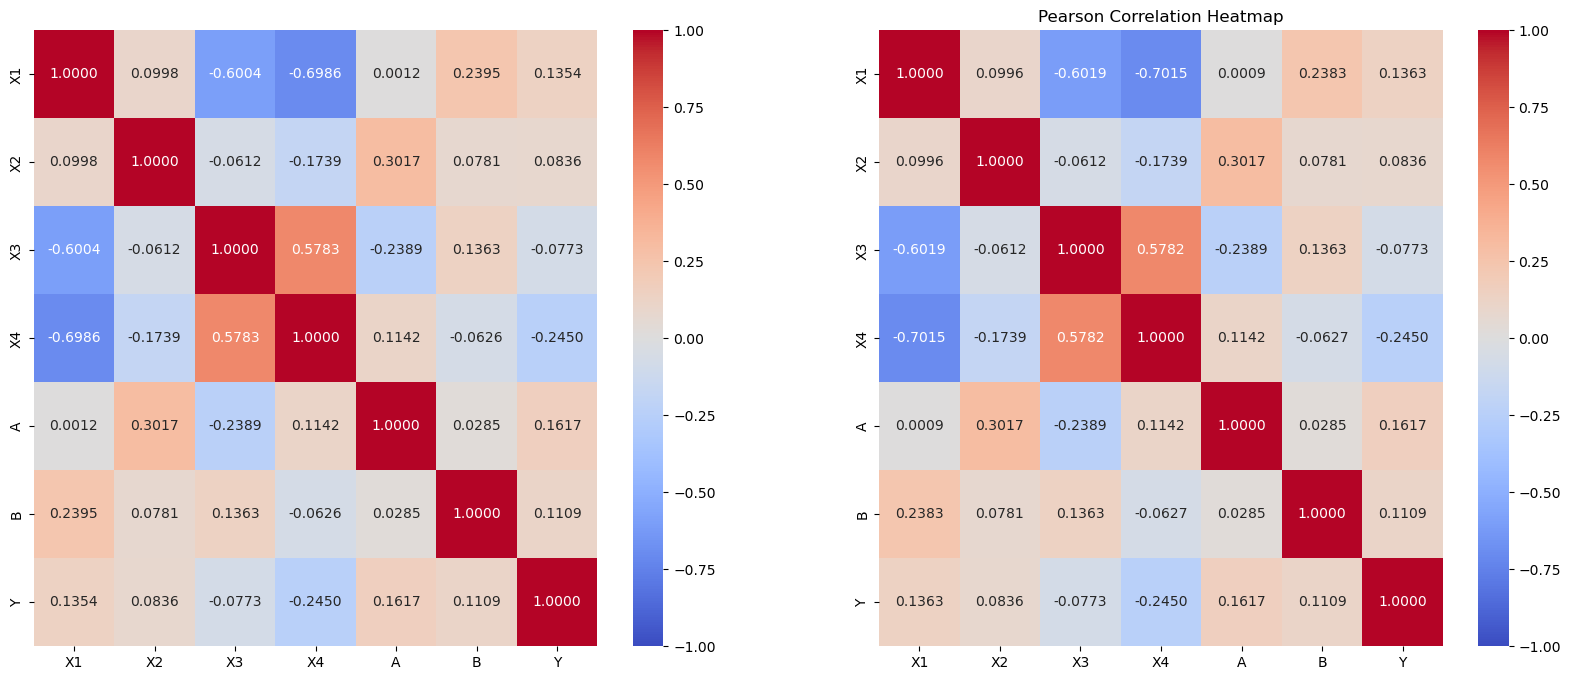

In [110]:
index = 0
df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B_Y], axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[index].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [27]:
num_epochs = 50
encoder.train()
predictor.train()
adversaryA.train()
adversaryB.train()

gradient_norms_advA = []
gradient_norms_advB = []
gradient_norms_enc = []
gradient_norms_pred = []
epochs_total = []

In [69]:
for epoch in range(num_epochs):
    
    total_gradient_norm_A = 0.0
    total_gradient_norm_B = 0.0
    total_gradient_norm_enc = 0.0
    total_gradient_norm_pred = 0.0
    num_batches_adv = 0
    num_batches_other = 0

    for data, labels in dataloader: 
        adversaryA.zero_grad()
        adversaryB.zero_grad()
        x_recon = encoder(data)
        adv_predA = adversaryA(x_recon)
        adv_predB = adversaryB(x_recon)
        laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
        laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
        laA.backward(retain_graph=True)
        laB.backward()
        
        batch_gradient_norm_A = 0.0
        for p in adversaryA.parameters():
            if p.grad is not None:
                batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
        total_gradient_norm_A += batch_gradient_norm_A

        batch_gradient_norm_B = 0.0
        for p in adversaryB.parameters():
            if p.grad is not None:
                batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
        batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
        total_gradient_norm_B += batch_gradient_norm_B

        num_batches_adv += 1

        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

        optimizer_advA.step()
        optimizer_advB.step()
        
    for data, labels in dataloader: 
        pass
    
    encoder.zero_grad()
    predictor.zero_grad()
    x_recon = encoder(data)
    y_pred = predictor(x_recon)
    adv_predA = adversaryA(x_recon)
    adv_predB = adversaryB(x_recon)

    lx = criterion_enc(x_recon, data[:,:4])
    lp = criterion_pred(y_pred, labels)
    laA = criterion_advA(adv_predA, data[:,4].view(-1,1).float())
    laB = criterion_advB(adv_predB, data[:,5].view(-1,1).float())
    
    combined_loss = lx + lp - (10 * (laA + laB))
#     combined_loss = lx + lp - (laA + laB)
    combined_loss.backward()

    for p in adversaryA.parameters():
        if p.grad is not None:
            batch_gradient_norm_A += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_A = batch_gradient_norm_A ** 0.5
    total_gradient_norm_A += batch_gradient_norm_A
    
    for p in adversaryB.parameters():
        if p.grad is not None:
            batch_gradient_norm_B += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_B = batch_gradient_norm_B ** 0.5
    total_gradient_norm_B += batch_gradient_norm_B

    batch_gradient_norm_enc = 0.0
    for p in encoder.parameters():
        if p.grad is not None:
            batch_gradient_norm_enc += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_enc = batch_gradient_norm_enc ** 0.5
    total_gradient_norm_enc += batch_gradient_norm_enc

    batch_gradient_norm_pred = 0.0
    for p in predictor.parameters():
        if p.grad is not None:
            batch_gradient_norm_pred += p.grad.data.norm(2).item() ** 2
    batch_gradient_norm_pred = batch_gradient_norm_pred ** 0.5
    total_gradient_norm_pred += batch_gradient_norm_pred


    num_batches_other += 1
    num_batches_adv += 1

    torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(adversaryA.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(adversaryB.parameters(), 1.0)

    optimizer_pred.step()
    optimizer_enc.step()

    
    average_gradient_norm_A = total_gradient_norm_A / num_batches_adv
    gradient_norms_advA.append(average_gradient_norm_A)

    average_gradient_norm_B = total_gradient_norm_B / num_batches_adv
    gradient_norms_advB.append(average_gradient_norm_B)
    
    average_gradient_norm_enc = total_gradient_norm_enc / num_batches_other
    gradient_norms_enc.append(average_gradient_norm_enc)

    average_gradient_norm_pred = total_gradient_norm_pred / num_batches_other
    gradient_norms_pred.append(average_gradient_norm_pred)

    epochs_total.append(epoch)

#     print("num_batches_adv",num_batches_adv)
#     print("num_batches_other",num_batches_other)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss A: {laA.item():.4f}, Loss B: {laB.item():.4f}, Loss Recon: {lx.item():.4f}, Loss P: {lp.item():.4f}, Loss Comb: {combined_loss.item():.4f}')

Epoch [1/50], Loss A: 0.5922, Loss B: 0.3670, Loss Recon: 0.2480, Loss P: 0.4985, Loss Comb: -8.8459
Epoch [2/50], Loss A: 0.5956, Loss B: 0.3671, Loss Recon: 0.2489, Loss P: 0.4983, Loss Comb: -8.8799
Epoch [3/50], Loss A: 0.5977, Loss B: 0.3679, Loss Recon: 0.2509, Loss P: 0.4982, Loss Comb: -8.9065
Epoch [4/50], Loss A: 0.5976, Loss B: 0.3688, Loss Recon: 0.2539, Loss P: 0.4981, Loss Comb: -8.9117
Epoch [5/50], Loss A: 0.5952, Loss B: 0.3694, Loss Recon: 0.2577, Loss P: 0.4981, Loss Comb: -8.8894
Epoch [6/50], Loss A: 0.5911, Loss B: 0.3694, Loss Recon: 0.2619, Loss P: 0.4982, Loss Comb: -8.8451
Epoch [7/50], Loss A: 0.5870, Loss B: 0.3688, Loss Recon: 0.2657, Loss P: 0.4984, Loss Comb: -8.7941
Epoch [8/50], Loss A: 0.5840, Loss B: 0.3681, Loss Recon: 0.2685, Loss P: 0.4986, Loss Comb: -8.7531
Epoch [9/50], Loss A: 0.5826, Loss B: 0.3674, Loss Recon: 0.2699, Loss P: 0.4989, Loss Comb: -8.7313
Epoch [10/50], Loss A: 0.5827, Loss B: 0.3672, Loss Recon: 0.2699, Loss P: 0.4992, Loss Com

In [70]:
len(epochs_total)

300

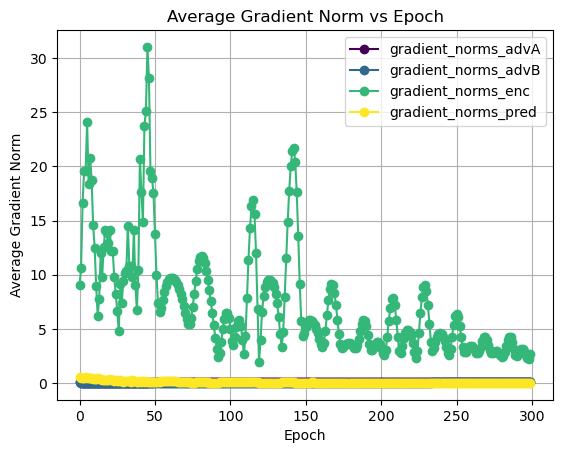

In [71]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

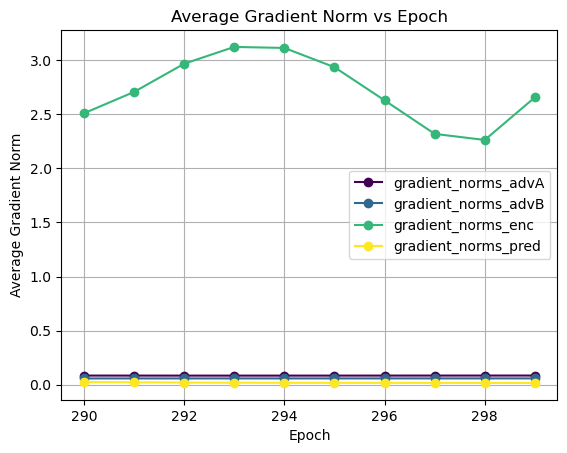

In [72]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advA[-10:], color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_advB[-10:], color=colors[1], marker='o', label='gradient_norms_advB')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_enc[-10:], color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total)))[-10:], gradient_norms_pred[-10:], color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

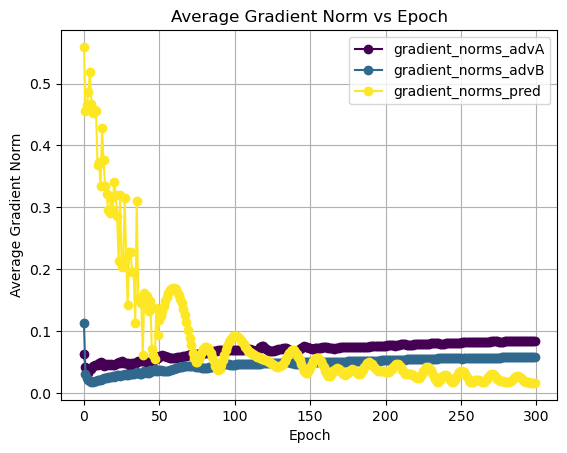

In [73]:
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, 4))
plt.plot(list(range(len(epochs_total))), gradient_norms_advA, color=colors[0], marker='o', label='gradient_norms_advA')
plt.plot(list(range(len(epochs_total))), gradient_norms_advB, color=colors[1], marker='o', label='gradient_norms_advB')
# plt.plot(list(range(len(epochs_total))), gradient_norms_enc, color=colors[2], marker='o', label='gradient_norms_enc')
plt.plot(list(range(len(epochs_total))), gradient_norms_pred, color=colors[3], marker='o', label='gradient_norms_pred')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Gradient Norm')
plt.title('Average Gradient Norm vs Epoch')
plt.grid(True)
plt.show()

In [74]:
# index = 0
# df = pd.DataFrame(encoder(torch.tensor(datasets[index][['X1','X2','X3','X4','A','B']].values, dtype=torch.float32)).detach().numpy(), columns=['X1', 'X2', 'X3', 'X4'])
# df_A_B_Y = datasets[index].copy()[['A', 'B', 'Y']].reset_index(drop=True)
# df = pd.concat([df, df_A_B_Y], axis=1)
# correlation_matrix = df.corr()
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
# plt.title('Pearson Correlation Heatmap')
# plt.show()

In [77]:
index = 0
df_original = datasets[index].copy()

dataset = CustomDataset(df_original)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

encoder_outputs = []
encoder.eval()
with torch.no_grad():
    for batch_X, _ in dataloader:
        output = encoder(batch_X)
        encoder_outputs.append(output)
encoder_outputs = torch.cat(encoder_outputs, dim=0)
print(encoder_outputs.shape)

encoder_outputs_np = encoder_outputs.numpy()
df = pd.DataFrame(encoder_outputs_np, columns=['X1', 'X2', 'X3', 'X4'])

df_A_B = df_original[['A', 'B', 'Y']].reset_index(drop=True)
df = pd.concat([df, df_A_B], axis=1)

correlation_matrix = df.corr()

torch.Size([100000, 4])


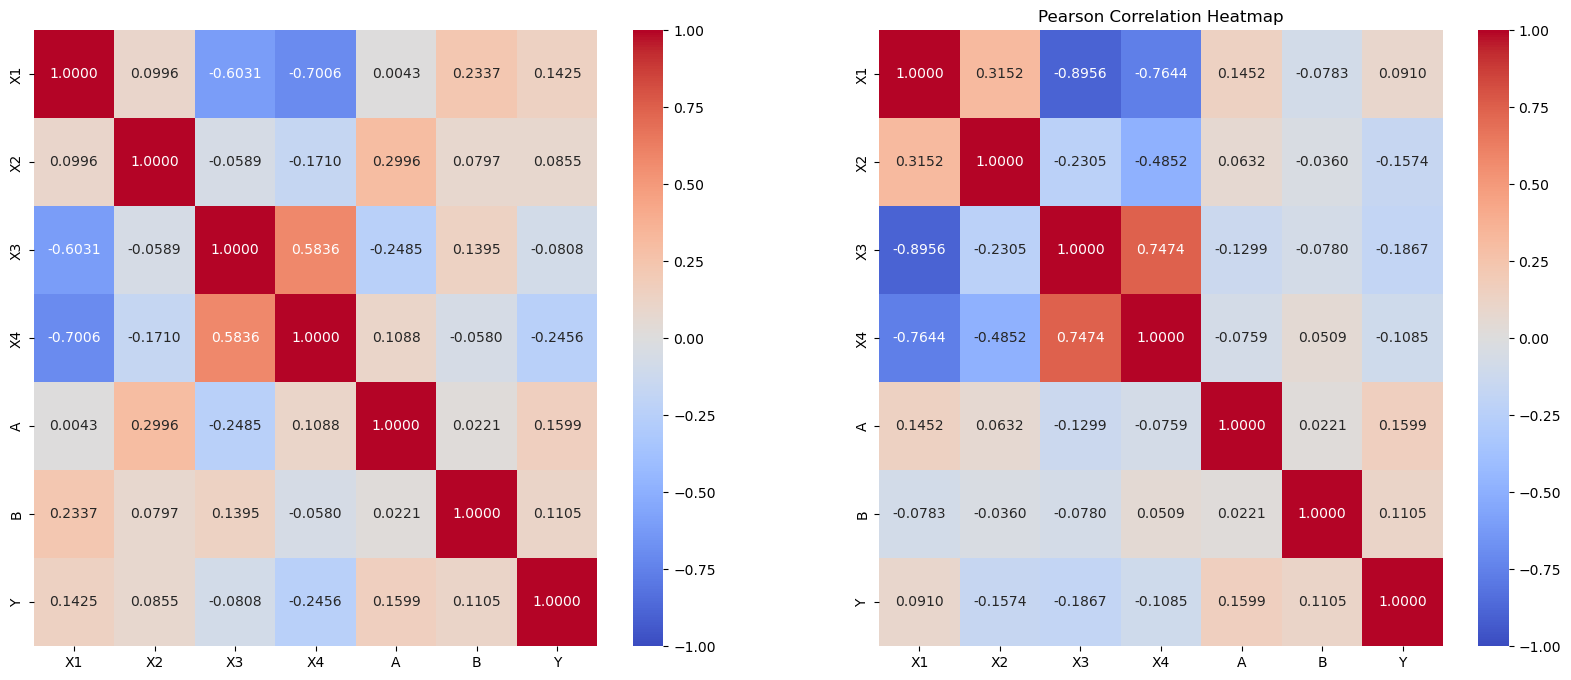

In [35]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

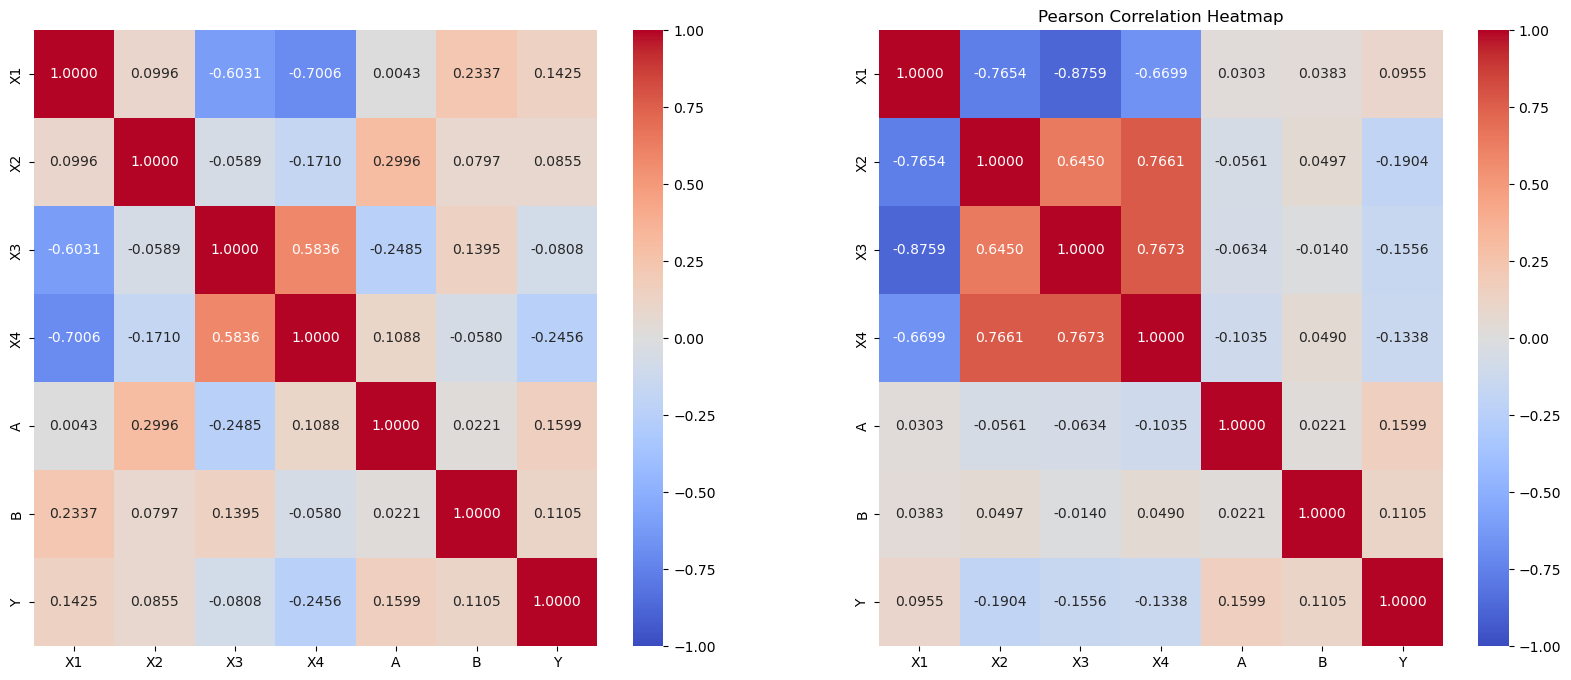

In [43]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

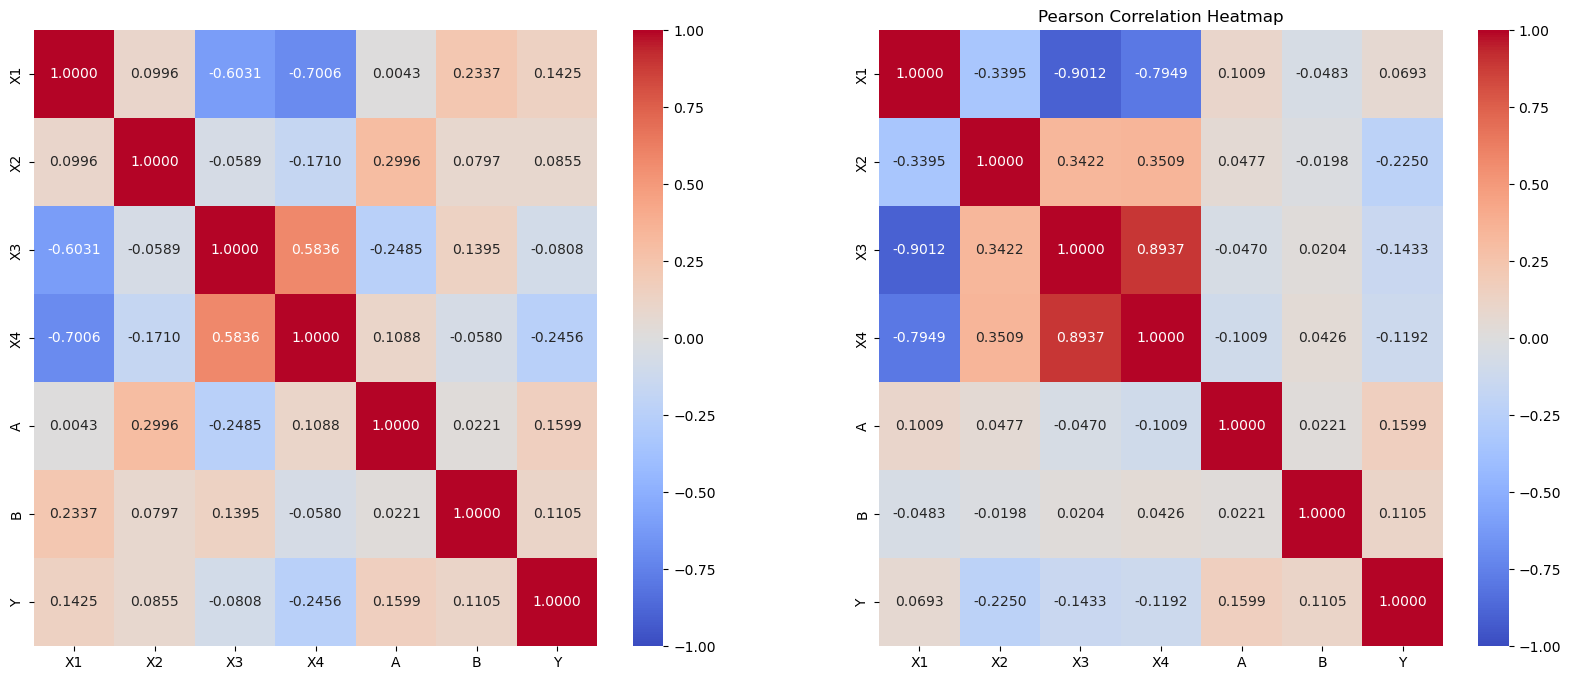

In [52]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

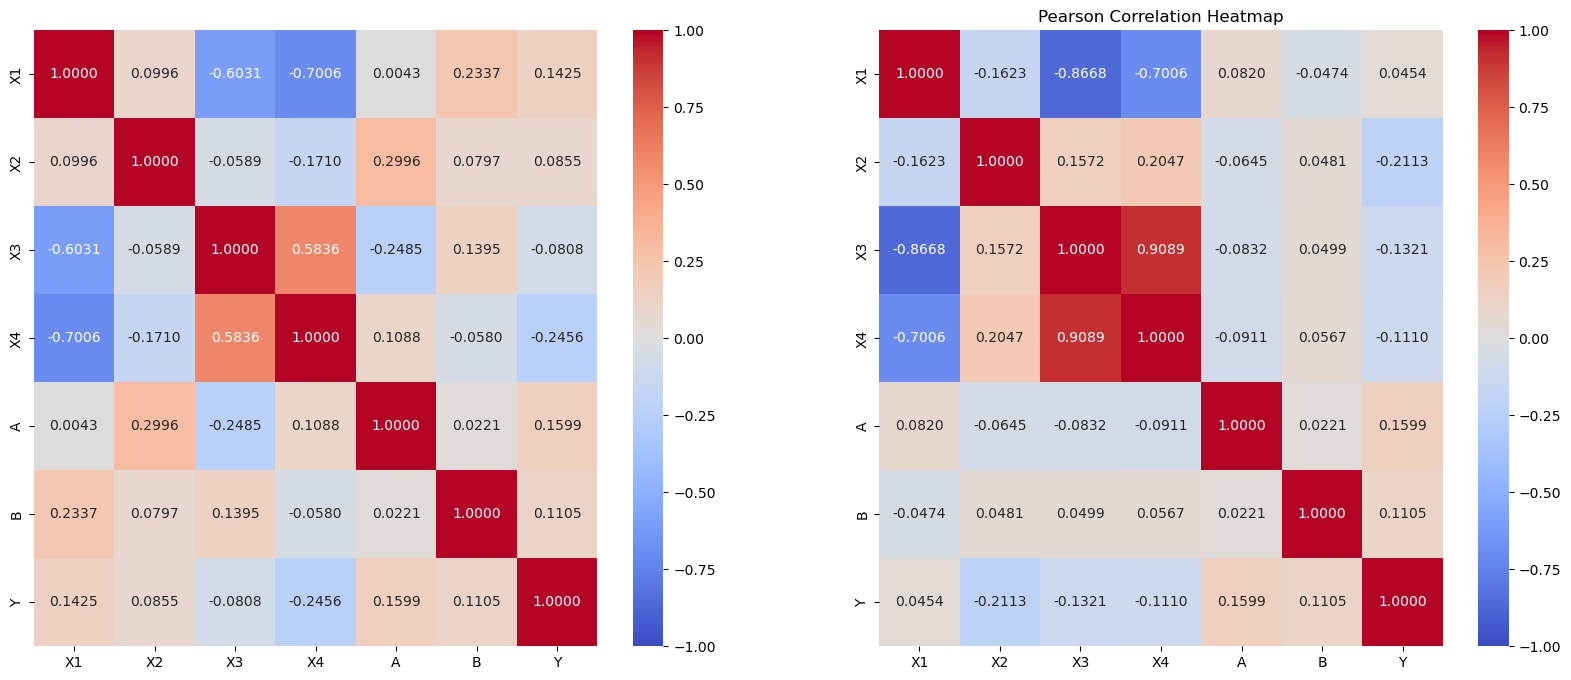

In [60]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

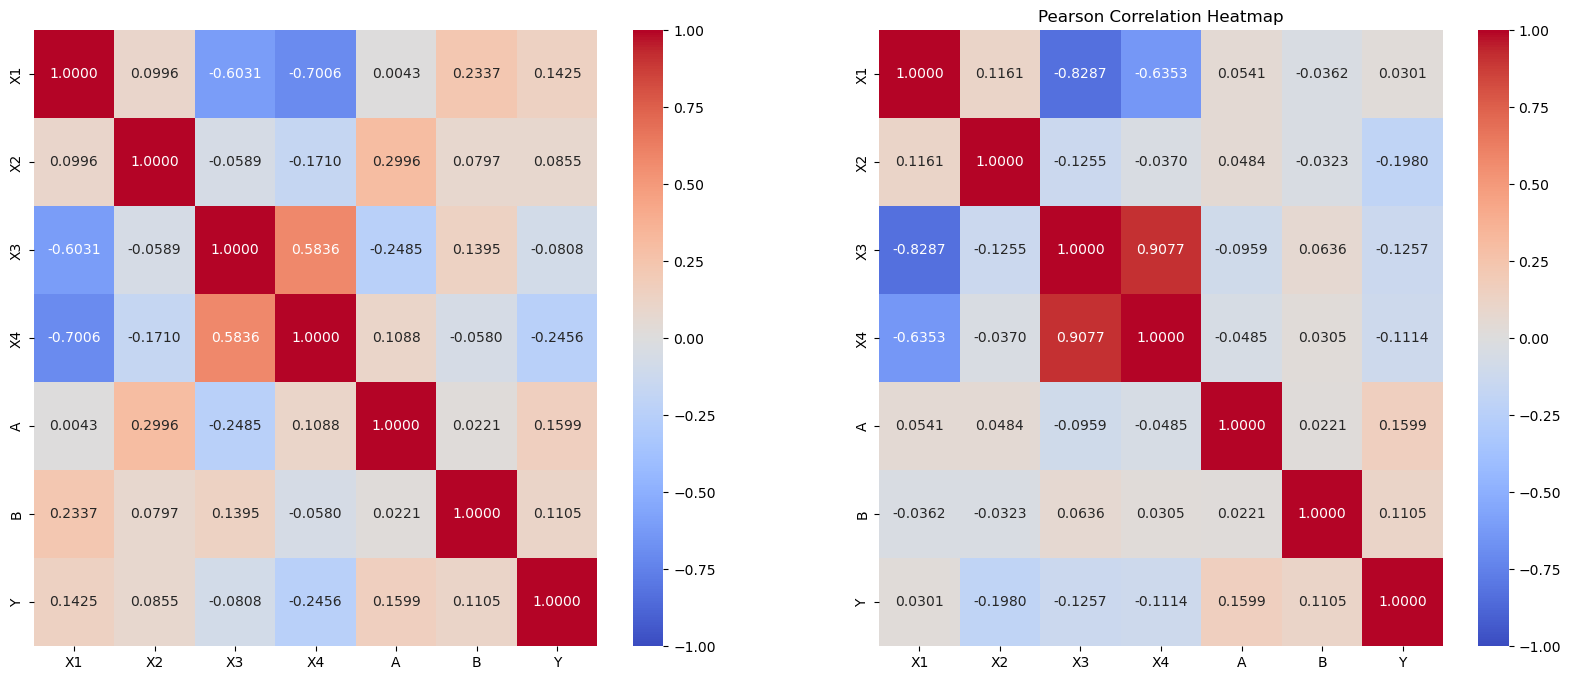

In [68]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

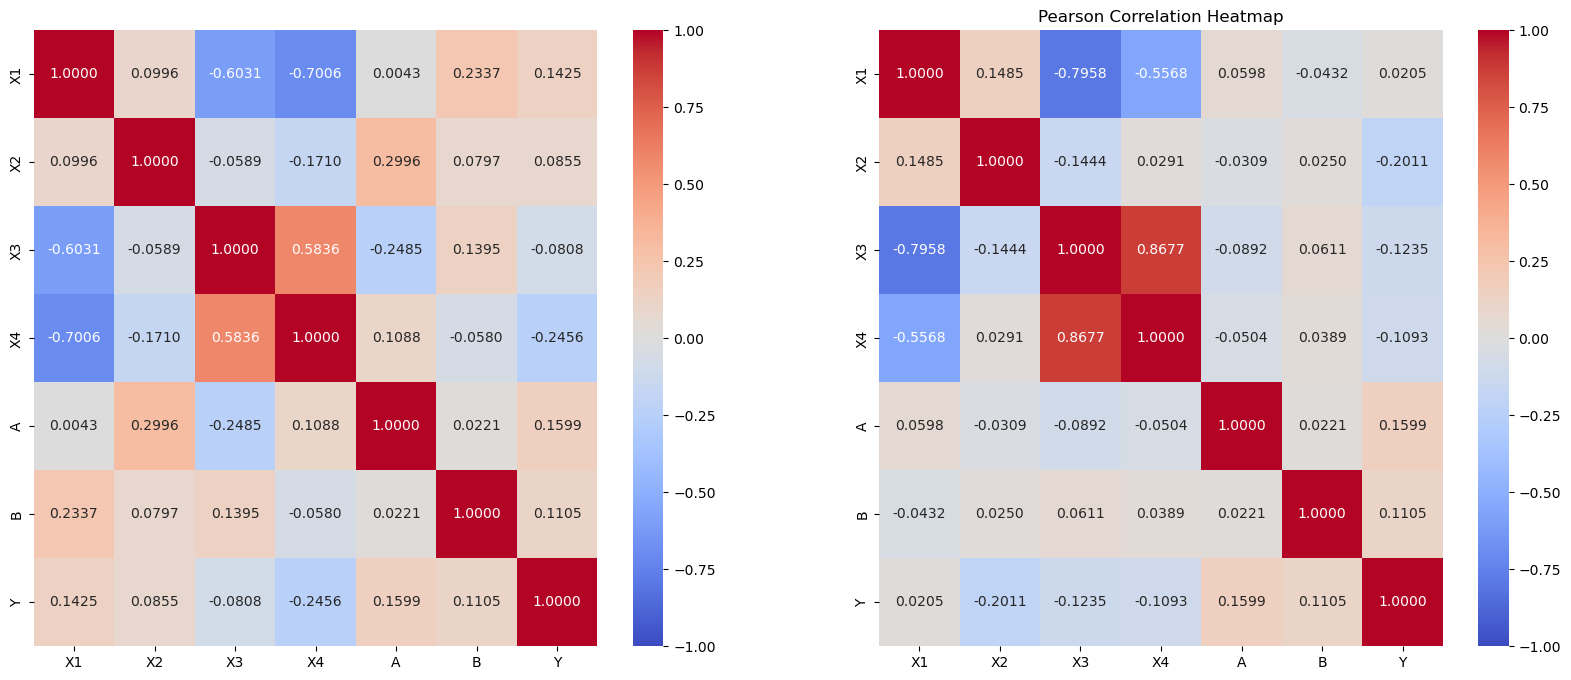

In [76]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.heatmap(datasets[0].corr(), annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.subplot(1,2,2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.4f', vmin=-1, vmax=1)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [177]:
loss_fn = nn.BCELoss()

In [ ]:
encoder(torch.tenso)
loss_fn()

In [182]:
y = np.random.randint(0,2, size=10000)
y

array([0, 1, 1, ..., 0, 0, 1])

In [184]:
y_hat = 1-y
y_hat

array([1, 0, 0, ..., 1, 1, 0])

In [185]:
from sklearn.metrics import log_loss

In [189]:
log_loss(y,y_hat)

36.043653389117146

In [187]:
log_loss(y,y)

2.2204460492503136e-16